# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [88]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from catboost import Pool, cv
import catboost as cb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
# импортируем необходимые библиотеки

### Изучение данных

In [3]:
df = pd.read_csv('/datasets/autos.csv')
# читаем датасет

In [4]:
df.info()
# смотрим общую информацию о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.head()
# выводим первые пять строк датасета для ознакомления

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
# удаляем ненужные столбцы

In [7]:
df.describe()
# смотрим информацию о данных датасета

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645
std,4514.158514,90.227958,189.850405,37905.341530,3.726421
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


In [8]:
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Обработка пропусков

In [9]:
df.isna().sum()
# смотрим количество пропусков

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
dtype: int64

In [10]:
df[df['VehicleType'].isna()].head()
# выводим строки с пропусками для ознакомления

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
16,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN
22,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no
26,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no
31,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN


In [11]:
df['VehicleType'] = df['VehicleType'].fillna('car')
# заменяем пропуски заглушкой

In [12]:
df[df['Gearbox'].isna()].head()
# выводим строки с пропусками для ознакомления

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN
16,300,car,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN
32,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no
37,1500,car,2016,NaN,0,kangoo,150000,1,gasoline,renault,no
40,0,car,1990,NaN,0,corsa,150000,1,petrol,opel,NaN


In [13]:
df['Gearbox'].value_counts(normalize=True)
# смотрим соотношение категориальных значений

manual    0.80186
auto      0.19814
Name: Gearbox, dtype: float64

In [14]:
df['Gearbox'] = df['Gearbox'].fillna('manual', limit=15866)
# заменяем пропуски, сохраняя соотношение категориальных признаков

In [15]:
df['Gearbox'] = df['Gearbox'].fillna('auto')
# заменяем пропуски, сохраняя соотношение категориальных признаков

In [16]:
df['Gearbox'].value_counts(normalize=True)
# смотрим, не изменилось ли соотношение 

manual    0.801755
auto      0.198245
Name: Gearbox, dtype: float64

In [17]:
df['Gearbox'].isna().sum()
# смотрим количество пропусков

0

In [18]:
df[df['Model'].isna()].head()
# выводим первые пять строк с пропусками для ознакомления

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
59,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN
81,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes
115,0,small,1999,manual,0,NaN,5000,0,petrol,volkswagen,NaN
135,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no


In [19]:
df['Model'] = df['Model'].fillna('none')
# заменяем признаки заглушкой

In [20]:
df['Model'].isna().sum()
# смотрим количество пропусков

0

In [21]:
df[df['FuelType'].isna()].head()
# выводим первые пять строк с пропусками для ознакомления

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
9,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN
13,2500,wagon,2004,manual,131,passat,150000,2,NaN,volkswagen,no
26,5555,car,2017,manual,125,c4,125000,4,NaN,citroen,no
36,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN
41,7500,sedan,2002,auto,306,e_klasse,150000,4,NaN,mercedes_benz,NaN


In [22]:
df['FuelType'].value_counts(normalize=True)
# смотрим соотношение категориальных признаков

petrol      0.673000
gasoline    0.307085
lpg         0.016518
cng         0.001758
hybrid      0.000725
other       0.000635
electric    0.000280
Name: FuelType, dtype: float64

In [23]:
df['FuelType'] = df['FuelType'].fillna('petrol', limit=22039)
# заменяем пропуски

In [24]:
df['FuelType'] = df['FuelType'].fillna('gasoline', limit=9869)
# заменяем пропуски

In [25]:
df['FuelType'] = df['FuelType'].fillna('lpg')
# заменяем пропуски

In [26]:
df['FuelType'].value_counts(normalize=True)
# смотрим соотношение категориальных признаков

petrol      0.672720
gasoline    0.306429
lpg         0.017770
cng         0.001594
hybrid      0.000658
other       0.000576
electric    0.000254
Name: FuelType, dtype: float64

In [27]:
df['FuelType'].isna().sum()
# смотрим количество пропусков

0

In [28]:
df['NotRepaired'].isna().sum()
# выводим первые пять строк с пропусками

71154

In [29]:
df['NotRepaired'].value_counts(normalize=True)

no     0.872697
yes    0.127303
Name: NotRepaired, dtype: float64

In [30]:
df['NotRepaired'] = df['NotRepaired'].fillna('no', limit=61904)
# заменяем пропуски

In [31]:
df['NotRepaired'] = df['NotRepaired'].fillna('yes')
# заменяем пропуски

In [32]:
df['NotRepaired'].isna().sum()
# проверяем количество пропусков

0

In [33]:
df['NotRepaired'].value_counts(normalize=True)

no     0.872156
yes    0.127844
Name: NotRepaired, dtype: float64

### Удаление выбросов

In [34]:
pd.DataFrame(df['RegistrationYear'].unique()).sort_values(by=0, ascending=False)
# смотрим на перечень значений в столбце

,0
67,9999
134,9996
119,9450
143,9229
91,9000
...,...
102,1200
39,1111
133,1039
118,1001


In [35]:
df.loc[(df['RegistrationYear'] < 1950), 'RegistrationYear'] = df['RegistrationYear'].median()
df.loc[(df['RegistrationYear'] >2016), 'RegistrationYear'] = df['RegistrationYear'].median()
# заменяем выбросы на медиану

In [36]:
df['RegistrationYear'].unique()
# смотрим на перечень значений в столбце

array([1993., 2011., 2004., 2001., 2008., 1995., 1980., 2014., 1998.,
       2005., 2003., 2016., 2007., 2009., 2002., 1997., 1990., 1981.,
       1994., 1991., 1984., 2006., 1999., 2012., 2010., 2000., 1992.,
       2013., 1996., 1985., 1989., 2015., 1982., 1976., 1983., 1973.,
       1969., 1971., 1987., 1986., 1988., 1970., 1965., 1974., 1979.,
       1955., 1978., 1972., 1968., 1977., 1961., 1960., 1966., 1975.,
       1963., 1964., 1954., 1958., 1967., 1959., 1956., 1962., 1957.,
       1951., 1953., 1950., 1952.])

In [37]:
pd.DataFrame(df['Power'].unique()).sort_values(by=0, ascending=False)
# смотрим на перечень значений в столбце

,0
610,20000
679,19312
487,19211
507,19208
415,17932
...,...
294,4
432,3
256,2
309,1


In [38]:
df.loc[(df['Power'] < 30), 'Power'] = df['Power'].median()
df.loc[(df['Power'] > 700), 'Power'] = df['Power'].median()
# заменяем выбросы на медиану

In [39]:
df = df[df['Power'] != 0]
df[df['Power'] == 0].count()
# удаляем строки с ценой, равной 0

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
dtype: int64

In [40]:
df = df[df['Price'] > 100]
df[df['Price'] == 0].count()
# удаляем строки с ценой, равной 0

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
dtype: int64

In [41]:
df.Price.describe()

count    340024.000000
mean       4602.471902
std        4514.902742
min         101.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

In [42]:
df.isna().sum()
# проверяем количество пропусков

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
dtype: int64

### Оптимизация данных

In [43]:
df.dtypes
# смотрим на типы данных

Price                  int64
VehicleType           object
RegistrationYear     float64
Gearbox               object
Power                float64
Model                 object
Kilometer              int64
RegistrationMonth      int64
FuelType              object
Brand                 object
NotRepaired           object
dtype: object

In [44]:
df['Price'] = df['Price'].astype('int32')
df['RegistrationYear'] = df['RegistrationYear'].astype('int16')
df['Power'] = df['Power'].astype('int16')
df['Kilometer'] = df['Kilometer'].astype('int32')
df['RegistrationMonth'] = df['RegistrationMonth'].astype('int8')
# меняем типы данных для экономии места и времени обработки

In [45]:
df.info()
# смотрим общую информацию о датасете

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340024 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              340024 non-null  int32 
 1   VehicleType        340024 non-null  object
 2   RegistrationYear   340024 non-null  int16 
 3   Gearbox            340024 non-null  object
 4   Power              340024 non-null  int16 
 5   Model              340024 non-null  object
 6   Kilometer          340024 non-null  int32 
 7   RegistrationMonth  340024 non-null  int8  
 8   FuelType           340024 non-null  object
 9   Brand              340024 non-null  object
 10  NotRepaired        340024 non-null  object
dtypes: int16(2), int32(2), int8(1), object(6)
memory usage: 22.4+ MB


**Вывод.**

Данные изучены, пропуски и выбросы обработаны, датасет оптимизирован. Можно приступать к подготовке признаков и обучению моделей.

## Подготовка признаков

### Кодирование категориальных значений

In [46]:
df_dum = pd.get_dummies(df)
# кодируемм категориальные признаки

In [47]:
df_dum.head()
# выводим первые пять строк получившейся таблицы

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_bus,VehicleType_car,VehicleType_convertible,VehicleType_coupe,VehicleType_other,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no,NotRepaired_yes
0,480,1993,105,150000,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190,125000,5,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,6,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,3600,2008,69,90000,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Подготовка обучающих признаков

In [48]:
features = df.drop(['Price'], axis=1)
features.shape
# выделяем признаки и смотрим на размер получившегося датасета

(340024, 10)

In [49]:
features_dum = df_dum.drop(['Price'], axis=1)
features_dum.shape
# выделяем признаки с закодированными категориальными значениями и смотрим на размер получившегося датасета

(340024, 315)

### Подготовка целевых признаков

In [50]:
target = df['Price']
target.shape
# выделяем целевой признак и смотрим на размер датасета

(340024,)

### Разделение на обучающую и тестовую выборки

In [51]:
features_train, features_test = train_test_split(features, test_size=0.2, random_state=12345)
print(features_train.shape, features_test.shape)
# делим признаки на обучающую и тестовую выборку и смотрим на размер получившихся датасетов

(272019, 10) (68005, 10)


In [52]:
features_dum_train, features_dum_test = train_test_split(features_dum, test_size=0.2, random_state=12345)
print(features_dum_train.shape, features_dum_test.shape)
# делим признаки с закодированными категориальными значения и смотрим на размер получившихся датасетов

(272019, 315) (68005, 315)


In [53]:
target_train, target_test = train_test_split(target, test_size=0.2, random_state=12345)
print(target_train.shape, target_test.shape)
# делим целевые признаки на обучающую и тестовую выборку

(272019,) (68005,)


### Выделение валидационной выборки

In [54]:
features_train, features_valid = train_test_split(features_train, test_size=0.25, random_state=12345)
print(features_train.shape, features_valid.shape)
# делим признаки на обучающую и тестовую выборку и смотрим на размер получившихся датасетов

(204014, 10) (68005, 10)


In [55]:
features_dum_train, features_dum_valid = train_test_split(features_dum_train, test_size=0.25, random_state=12345)
print(features_dum_train.shape, features_dum_valid.shape)
# делим признаки с закодированными категориальными значения и смотрим на размер получившихся датасетов

(204014, 315) (68005, 315)


In [56]:
target_train, target_valid = train_test_split(target_train, test_size=0.25, random_state=12345)
print(target_train.shape, target_valid.shape)
# делим целевые признаки на обучающую и тестовую выборку

(204014,) (68005,)


**Вывод**

Подготовили два типа обучающих признаков - с категориальными значениями (для бустинговых моделей) и без (для простых моделей), можно приступать к обучению и анализу моделей.

## Обучение и анализ моделей

### Dummy-модель

In [57]:
%%time

model = DummyRegressor()
model.fit(features_dum_train, target_train)
# обучаем модель и смотрим на скорость обучения

CPU times: user 1.17 ms, sys: 192 µs, total: 1.36 ms
Wall time: 816 µs


DummyRegressor()

In [58]:
%%time

predictions = model.predict(features_valid)
print('rmse =', mean_squared_error(target_valid, predictions) ** 0.5)
# смотрим на качество и скорость работы простой Dummy-модели для сравнения

rmse = 4512.043489284947
CPU times: user 0 ns, sys: 2.13 ms, total: 2.13 ms
Wall time: 1.54 ms


### Линейная регрессия

In [59]:
%%time

model = LinearRegression()
model.fit(features_dum_train, target_train)
# обучаем линейную регрессию и смотрим на скорость обучения

CPU times: user 13.5 s, sys: 4.81 s, total: 18.3 s
Wall time: 18.3 s


LinearRegression()

In [60]:
%%time

predictions = model.predict(features_dum_valid)
print('rmse =', mean_squared_error(target_valid, predictions) ** 0.5)
# смотрим на качество и скорость работы Линейной регресии

rmse = 2664.712805689988
CPU times: user 155 ms, sys: 109 ms, total: 264 ms
Wall time: 293 ms


### Случайный лес

In [79]:
%%time

rfr = RandomForestRegressor(random_state=12345)
param_grid = { 
    'n_estimators': range(1, 11),
    'max_depth': range(1, 11)
}

CV_rfr = RandomizedSearchCV(rfr, param_grid, scoring='neg_root_mean_squared_error', cv=3)
CV_rfr.fit(features_dum_train, target_train)
print('Лучшие гиперпараметры модели:', CV_rfr.best_params_)
print('Лучшее значение метрики rmse:', CV_rfr.best_score_)
# подбираем лучшие гиперпараметры и проводим кросс-валидацию методом RandomSearch

Лучшие гиперпараметры модели: {'n_estimators': 6, 'max_depth': 10}
Лучшее значение метрики rmse: -2004.6342362662401
CPU times: user 4min 33s, sys: 5.61 s, total: 4min 38s
Wall time: 4min 39s


In [82]:
%%time

model = RandomForestRegressor(n_estimators=10, max_depth=9, random_state=12345)
model.fit(features_dum_train, target_train)
# обучаем модель с подобранными гиперпараметрами и смотрим на скорость обучения

CPU times: user 26.8 s, sys: 240 ms, total: 27 s
Wall time: 27 s


RandomForestRegressor(max_depth=9, n_estimators=10, random_state=12345)

In [83]:
%%time

predictions = model.predict(features_dum_valid)
print('rmse =', mean_squared_error(target_valid, predictions) ** 0.5)
# смотрим на качество и скорость работы Случайного леса

rmse = 2047.7677640935717
CPU times: user 122 ms, sys: 43.2 ms, total: 165 ms
Wall time: 164 ms


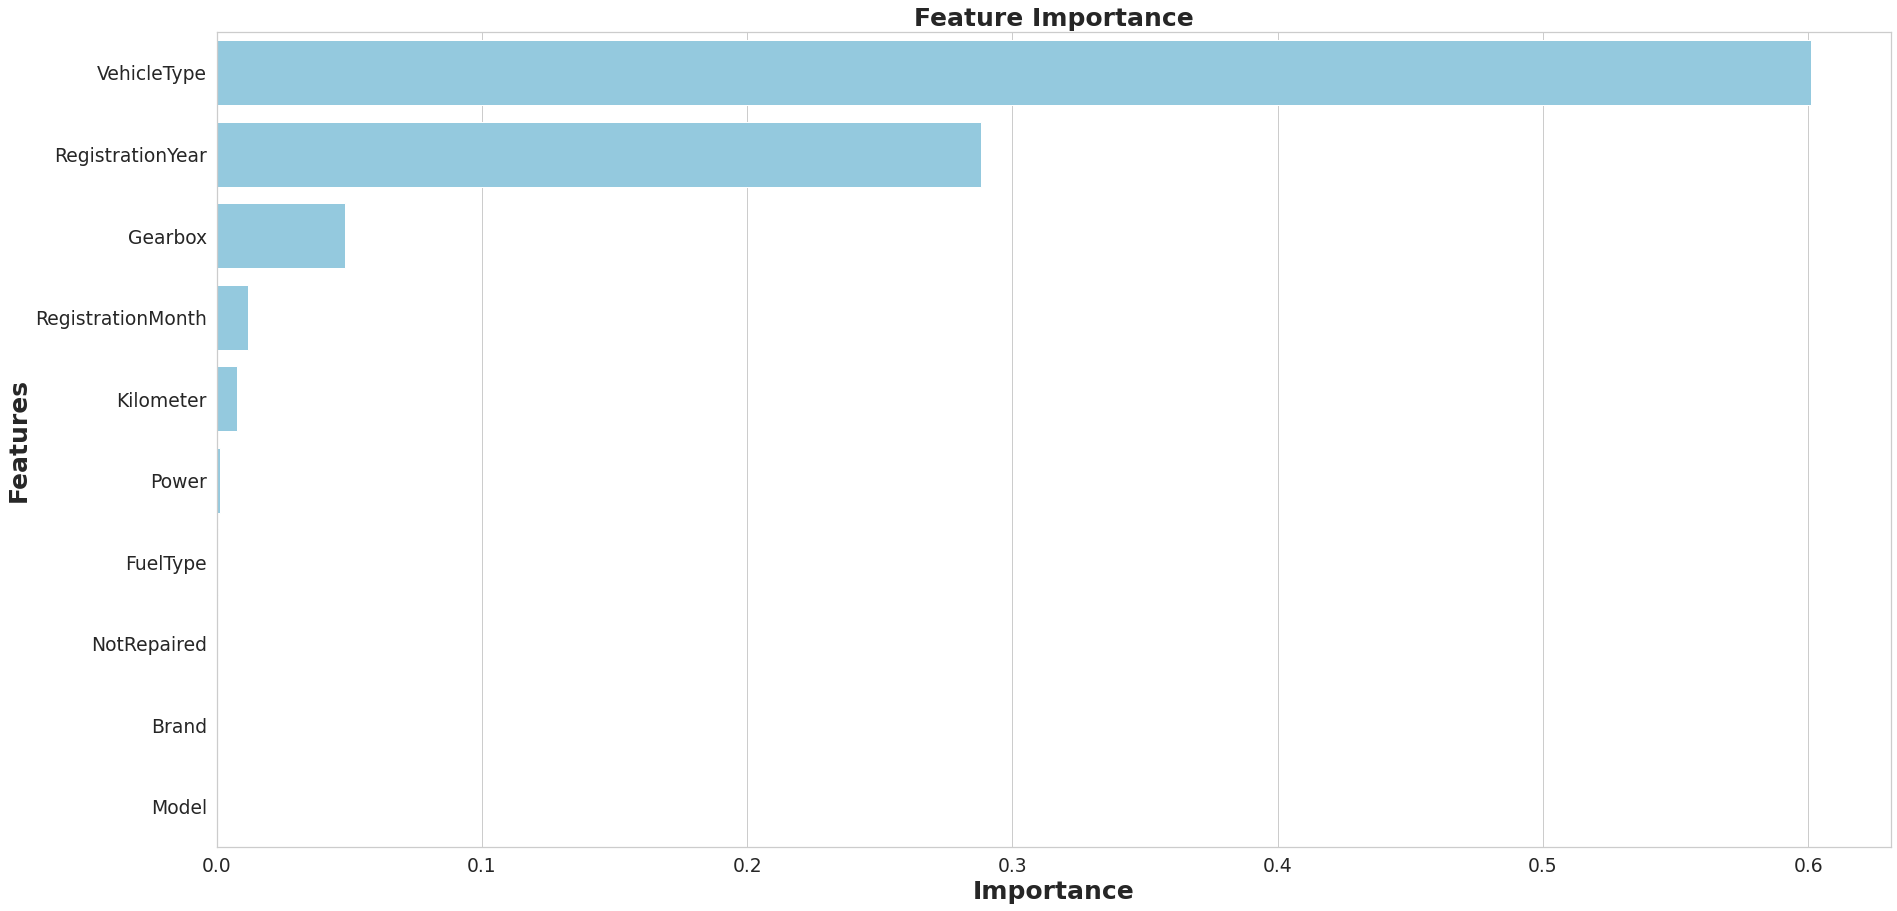

None

,Features,Gini-Importance
0,VehicleType,0.600944
1,RegistrationYear,0.288244
2,Gearbox,0.048222
3,RegistrationMonth,0.011893
4,Kilometer,0.007671
5,Power,0.001423
6,FuelType,0.000380
7,NotRepaired,0.000327
8,Brand,0.000049
9,Model,0.000041


In [89]:
feats = {}
for feature, importance in zip(features_train.columns, model.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

### CatBoost

In [64]:
%%time

cat_features = ['VehicleType', 'Gearbox', 'Model',
                'Brand', 'FuelType', 'NotRepaired']

model = CatBoostRegressor(verbose=0)
model.fit(features_train, target_train, cat_features=cat_features)
# обучаем модель и смотрим на скорость обучения

CPU times: user 2min 19s, sys: 990 ms, total: 2min 20s
Wall time: 2min 22s


In [65]:
%%time

predictions = model.predict(features_valid)
print('rmse =', mean_squared_error(target_valid, predictions) ** 0.5)
# смотрим на качество и скорость работы модели CatBoost для сравнения

rmse = 1678.02081704899
CPU times: user 428 ms, sys: 11.8 ms, total: 440 ms
Wall time: 442 ms


### LightGBM

In [66]:
cols_to_exclude = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
features_list = [features_train, features_valid, features_test]

for feature in features_list: 
    for col in feature.columns:
        if col not in cols_to_exclude:
            feature[col] = feature[col].astype('category')
    print(feature.dtypes)
    print()
# через цикл меняем значения типа object на тип category    

VehicleType          category
RegistrationYear        int16
Gearbox              category
Power                   int16
Model                category
Kilometer               int32
RegistrationMonth        int8
FuelType             category
Brand                category
NotRepaired          category
dtype: object

VehicleType          category
RegistrationYear        int16
Gearbox              category
Power                   int16
Model                category
Kilometer               int32
RegistrationMonth        int8
FuelType             category
Brand                category
NotRepaired          category
dtype: object

VehicleType          category
RegistrationYear        int16
Gearbox              category
Power                   int16
Model                category
Kilometer               int32
RegistrationMonth        int8
FuelType             category
Brand                category
NotRepaired          category
dtype: object



/tmp/ipykernel_48/2979518217.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature[col] = feature[col].astype('category')


In [68]:
%%time

model = LGBMRegressor()
model.fit(features_train, target_train)
# обучаем модель и смотрим на скорость обучения

CPU times: user 4.55 s, sys: 0 ns, total: 4.55 s
Wall time: 4.5 s


LGBMRegressor()

In [69]:
%%time

predictions = model.predict(features_valid)
print('rmse =', mean_squared_error(target_valid, predictions) ** 0.5)
# смотрим на качество и скорость работы модели LightGBM

rmse = 1703.0832619884156
CPU times: user 669 ms, sys: 0 ns, total: 669 ms
Wall time: 612 ms


In [70]:
%%time

model = LGBMRegressor(num_leaves=21, n_estimators=200)
model.fit(features_train, target_train)
# обучаем модель и смотрим на скорость обучения

CPU times: user 7.5 s, sys: 0 ns, total: 7.5 s
Wall time: 7.58 s


LGBMRegressor(n_estimators=200, num_leaves=21)

In [71]:
%%time

predictions = model.predict(features_valid)
print('rmse =', mean_squared_error(target_valid, predictions) ** 0.5)
# смотрим на качество и скорость работы модели с другими гиперпараметрами

rmse = 1696.3694477798213
CPU times: user 989 ms, sys: 0 ns, total: 989 ms
Wall time: 1 s


In [72]:
%%time

model = LGBMRegressor(num_leaves=30, n_estimators=500)
model.fit(features_train, target_train)
# обучаем модель и смотрим на скорость обучения

CPU times: user 16.7 s, sys: 0 ns, total: 16.7 s
Wall time: 16.9 s


LGBMRegressor(n_estimators=500, num_leaves=30)

In [73]:
%%time

predictions = model.predict(features_valid)
print('rmse =', mean_squared_error(target_valid, predictions) ** 0.5)
# смотрим на качество и скорость работы модели с другими гиперпараметрами

rmse = 1629.6674339565704
CPU times: user 2.53 s, sys: 0 ns, total: 2.53 s
Wall time: 2.53 s


In [74]:
%%time

model = LGBMRegressor(num_leaves=50, n_estimators=1000)
model.fit(features_train, target_train)
# обучаем модель и смотрим на скорость обучения

CPU times: user 53.7 s, sys: 70.8 ms, total: 53.8 s
Wall time: 54.2 s


LGBMRegressor(n_estimators=1000, num_leaves=50)

In [75]:
%%time

predictions = model.predict(features_valid)
print('rmse =', mean_squared_error(target_valid, predictions) ** 0.5)
# смотрим на качество и скорость работы модели с другими гиперпараметрами

rmse = 1597.5277658883615
CPU times: user 8.71 s, sys: 0 ns, total: 8.71 s
Wall time: 8.73 s


### Итоги исследования

In [ ]:
data = {'RMSE':[4512, 2664, 2047, 1678, 1703, 1696, 1629, 1597], 
        'Education time, s':[0.001, 18.3, 27, 132, 4.5, 7.58, 16.9, 54.2],
       'Work time, s':[0.001, 0.29, 0.16, 0.44, 0.6, 1, 2.53, 8.73]} 
df_total = pd.DataFrame(data, index =['Dummy', 'LinearRegression', 'RandomForestRegressor', 
                                'CatBoost', 'LightGBM', 
                                'LightGBM_21/200', 'LightGBM_30/500', 'LightGBM_50/1000']) 

In [92]:
display(df_total)

,RMSE,"Ed time, s","Wk time, s"
Dummy,4512,0.001,0.001
LinearRegression,2664,18.300,0.290
RandomForestRegressor,2047,27.000,0.160
CatBoost,1678,132.000,0.440
LightGBM,1703,4.500,0.600
LightGBM_21/200,1696,7.580,1.000
LightGBM_30/500,1629,16.900,2.530
LightGBM_50/1000,1597,54.200,8.730


### Выводы.

Как видно, наилучшую скорость и наихудшее качество показывает Dummy-модель.

Простые модели (Линейная регрессия и Случайный лес) показывают существенно лучшие результаты, Случайный лес даже выполняет требования задачи по значениям метрики, но, конечно, по скорости и проигрывают Dummy-модели.

Наилучшее качество в нашем исследовании показывают бустинговые модели - CatBoost и LightGBM, при этом они обе выполняют условие, что значение RMSE должно быть менее 2500.
При настройках по умолчанию, CatBoost показывает лучшее значение метрики и высокую скорость работы, но большее время обучения, что в данном случае не критично.
При подборе гиперпараметров, LightGBM обходит базовый CatBoost как по значениям метрики, так и по скорости обучения, но проигрывает по скорости работы.

С учётом того, что работать модель будет в мобильном приложении, ожидание в 1-3 сек. не кажется критичным, а вот отжидание 10 сек. каких-то пользователей может уже оттолкнуть.

Поэтому модель LightGBM с гиперпараметрами (n_estimators=500, num_leaves=30) мы можем рекомендовать для задачи предсказания стоимости автомобиля в мобильном приложении, у неё хорошее значение метрики и приемлимая скорость работы.

## Тестирование выбранной модели

In [76]:
%%time

model = LGBMRegressor(num_leaves=30, n_estimators=500)
model.fit(features_train, target_train)
# обучаем модель и смотрим на скорость обучения

CPU times: user 19.2 s, sys: 5.34 ms, total: 19.2 s
Wall time: 19.6 s


LGBMRegressor(n_estimators=500, num_leaves=30)

In [77]:
%%time

predictions = model.predict(features_test)
print('rmse =', mean_squared_error(target_test, predictions) ** 0.5)
# смотрим на качество и скорость работы модели с другими гиперпараметрами

rmse = 1624.0455347564607
CPU times: user 2.66 s, sys: 0 ns, total: 2.66 s
Wall time: 2.7 s


### Вывод.

Выбранная в ходе исследования модель показала невысокое время обучения и предсказания, а также хорошее значение метрики, так что можно рекомендовать её для решения поставленной задачи.